<a href="https://colab.research.google.com/github/RoyElkabetz/DQN_with_PyTorch_and_Gym/blob/main/dueling_ddqn_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing DQN Algorithms with PyTorch and Gym

## Clone the DQN repository

In [1]:
## uncomment only if running from google.colab
# clone the git reposetory
!git clone https://github.com/RoyElkabetz/DQN_with_PyTorch_and_Gym.git

# add path to .py files for import
import sys
sys.path.insert(1, "/content/DQN_with_PyTorch_and_Gym")

Cloning into 'DQN_with_PyTorch_and_Gym'...
remote: Enumerating objects: 439, done.
remote: Counting objects: 100% (439/439), done.
remote: Compressing objects: 100% (366/366), done.
remote: Total 439 (delta 235), reused 221 (delta 69), pack-reused 0
Receiving objects: 100% (439/439), 61.13 MiB | 6.63 MiB/s, done.
Resolving deltas: 100% (235/235), done.


## Mount your google drive to save results and checkpoints

In [2]:
## uncomment to mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Check GPU performance

In [3]:
# check GPU parameters
!nvidia-smi

Sun Oct 24 19:33:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install Gym and atari libraries

In [4]:
!pip install --quiet gym
!pip install --quiet atari_py

## Fetch and install ROMs for Atari library

In [5]:
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

--2021-10-24 19:34:04--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M   263KB/s    in 45s     

2021-10-24 19:34:50 (241 KB/s) - ‘Roms.rar’ saved [11128004/11128004]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Roms.rar

Extracting  /content/ROM/HC ROMS.zip                                      36%  OK 
Extracting  /content/ROM/ROMS.zip                                         74% 99%  OK 
All OK
copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin fr

## Train a DQN based agent in playing an atari game

In [6]:
import numpy as np
import gym
from agents import DuelingDDQNAgent
from utils import plot_learning_curve, make_env

record = False
load_checkpoint = False
env_name = 'SpaceInvadersNoFrameskip-v4'
algo = 'DuelingDDQNAgent'

env = make_env(env_name)
if record:
    env = gym.wrappers.Monitor(env, "recording", force=True)
best_score = -np.inf
n_games = 1000
agent = DuelingDDQNAgent(gamma=0.99, epsilon=1.0, lr=1e-4,
                          input_dims=(env.observation_space.shape),
                          n_actions=env.action_space.n,
                          mem_size=20000,
                          eps_min=0.1,
                          batch_size=32,
                          replace=5000,
                          eps_dec=1e-5,
                          chkpt_dir='gdrive/MyDrive/Checkpoints/',
                          algo=algo,
                          env_name=env_name)
if load_checkpoint:
    agent.load_models()

fname = agent.algo + '_' + agent.env_name + '_lr_' + str(agent.lr) + '_' + str(n_games) + '_games'
figure_file = 'gdrive/MyDrive/Checkpoints/' + fname + '.png'

n_steps = 0
scores, eps_history, steps_array = [], [], []

for i in range(n_games):
    done = False
    score = 0
    observation = env.reset()

    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward

        if not load_checkpoint:
            agent.store_transition(observation, action, reward, observation_, int(done))
            agent.learn()

        observation = observation_
        n_steps += 1
    scores.append(score)
    steps_array.append(n_steps)

    avg_score = np.mean(scores[-100:])
    print('episode ', i, 'score: ', score, 'average score %.1f best score %.1f epsilon %.2f' %
          (avg_score, best_score, agent.epsilon), 'steps ', n_steps)

    if avg_score > best_score:
        if not load_checkpoint:
            agent.save_models()
        best_score = avg_score

    eps_history.append(agent.epsilon)
env.close()

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/content/DQN_with_PyTorch_and_Gym/agents.py:229: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  q_next[dones] = 0.0


episode  0 score:  120.0 average score 120.0 best score -inf epsilon 1.00 steps  506
... saving checkpoint ...
... saving checkpoint ...
episode  1 score:  120.0 average score 120.0 best score 120.0 epsilon 0.99 steps  982
episode  2 score:  185.0 average score 141.7 best score 120.0 epsilon 0.98 steps  1591
... saving checkpoint ...
... saving checkpoint ...
episode  3 score:  110.0 average score 133.8 best score 141.7 epsilon 0.98 steps  2128
episode  4 score:  55.0 average score 118.0 best score 141.7 epsilon 0.98 steps  2410
episode  5 score:  105.0 average score 115.8 best score 141.7 epsilon 0.97 steps  2887
episode  6 score:  75.0 average score 110.0 best score 141.7 epsilon 0.97 steps  3264
episode  7 score:  135.0 average score 113.1 best score 141.7 epsilon 0.96 steps  3774
episode  8 score:  110.0 average score 112.8 best score 141.7 epsilon 0.96 steps  4178
episode  9 score:  110.0 average score 112.5 best score 141.7 epsilon 0.95 steps  4538
episode  10 score:  180.0 avera

## Plot and save learning curve

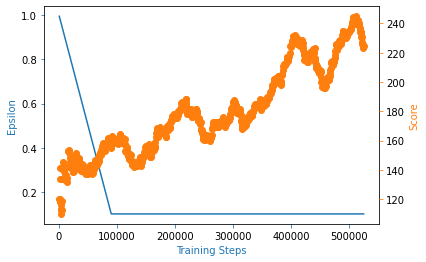

In [7]:
plot_learning_curve(steps_array, scores, eps_history, figure_file)